In [5]:
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns

import pandas as pd
import numpy as np
import cv2
import scipy as sp

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MeanShift, AgglomerativeClustering, SpectralClustering, DBSCAN

import os
from collections import Counter
import warnings


In [6]:
warnings.filterwarnings('ignore')

In [7]:
def load_images(path: str, mode: str='RGB') -> np.ndarray:
    
    conversion_attr = f"COLOR_BGR2{mode}"
    conversion_code = getattr(cv2, conversion_attr)
    
    images = []
    for file in os.listdir(path):
        if file.lower().endswith('.jpg'):
            img_path = os.path.join(path, file)
            img_bgr = cv2.imread(img_path)
            if img_bgr is None:
                continue
            img = cv2.cvtColor(img_bgr, conversion_code)
            images.append(img)
            
    return np.array(images)

# EDA

In [19]:
data = load_images('data/$learning_2', mode='RGB')

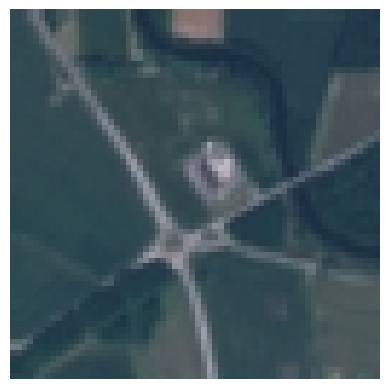

In [74]:
im = data[12]
plt.imshow(im)
plt.axis('off');

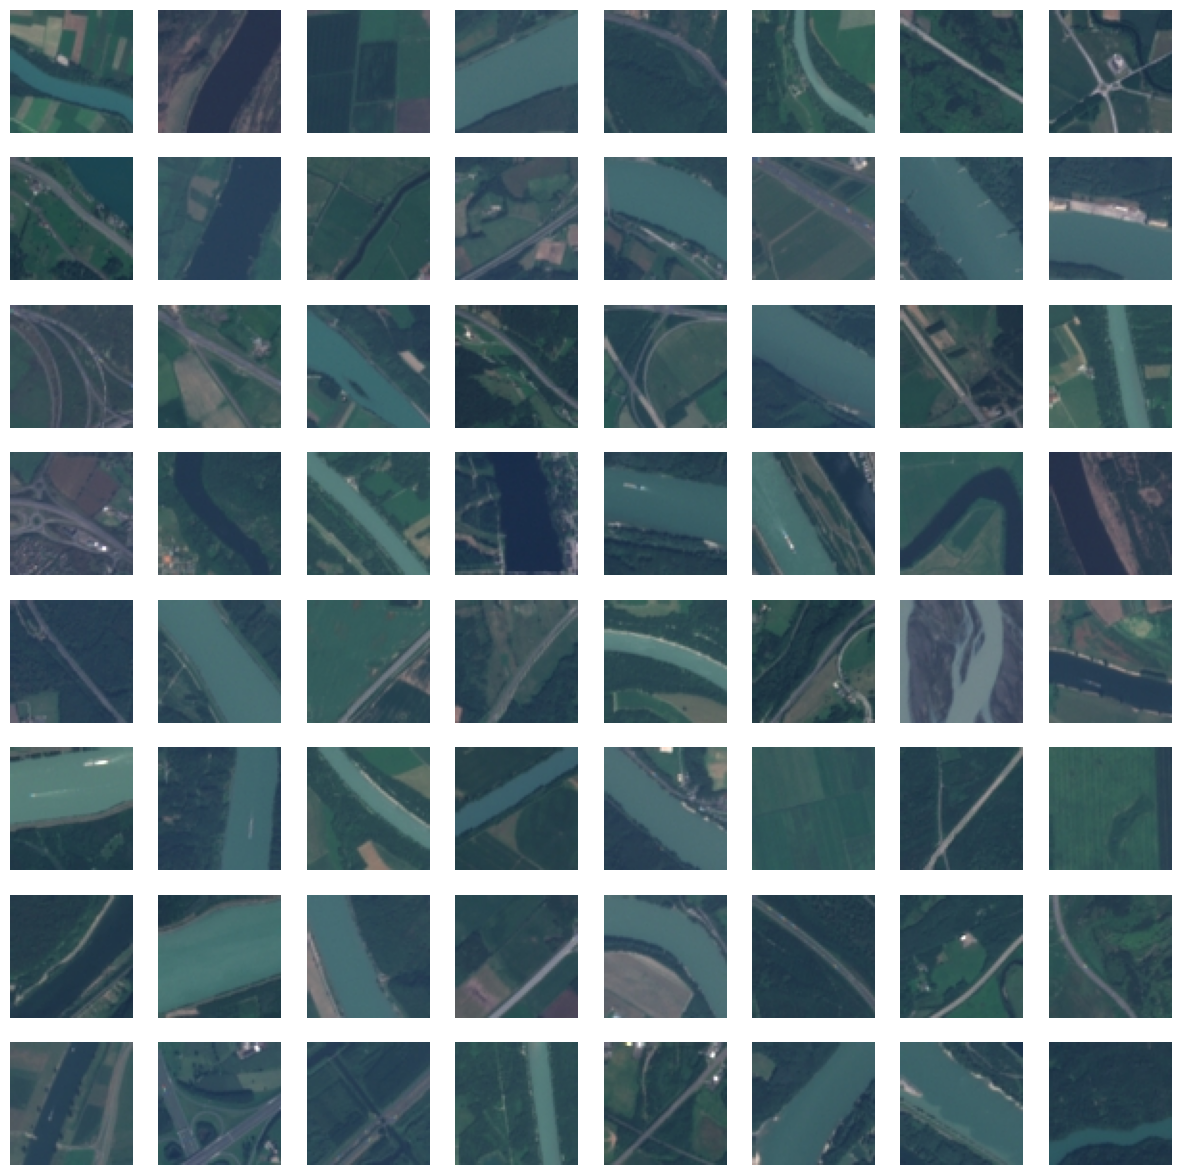

In [75]:
fig, ax = plt.subplots(8, 8, figsize=(15, 15), dpi=100)

np.random.seed(42)
indexes = np.random.choice(64, 64, replace=False)
random_images = iter(data[indexes])

for i in range(8):
    for j in range(8):
        ax[i][j].imshow(next(random_images))
        ax[i][j].axis('off')

# K-Means

In [7]:
def plot_multiple_Kmeans_analysis(data, reps: int=20, k_values=range(3, 10), mode: str='RGB'):

    all_pixels = data.reshape(-1, 3)
    kmeans_models = {k: KMeans(n_clusters=k, random_state=42).fit(all_pixels) for k in k_values}

    if mode != 'RGB':
        conversion_code = getattr(cv2, f"COLOR_{mode}2RGB")
        
    used = list()

    dist_x = int((len(kmeans_models) + 1) * 1.8) # some fucking magic numbers there
    dist_y = int(reps * 2.2)
    fig, ax = plt.subplots(reps, len(kmeans_models) + 1, figsize=(dist_x, dist_y), dpi=100)

    for i in range(reps):
        
        num = np.random.randint(0, len(data))
        while num in used:
            num = np.random.randint(0, len(data))
        used.append(num)

        im = data[num]
        
        if mode != 'RGB':
            im = cv2.cvtColor(im, conversion_code)
            
        ax[i, 0].imshow(im)
        ax[i, 0].axis('off')
        ax[i, 0].set_title(f'Original {num}')

        pixels = data[num].reshape(-1, 3)

        for idx, k in enumerate(k_values, start=1):
            model = kmeans_models[k]
            labels = model.predict(pixels)
            segmented_img = model.cluster_centers_[labels]
            segmented_img = segmented_img.reshape(data[num].shape)
            segmented_img = segmented_img.astype(np.uint8)
            
            if mode != 'RGB':
                segmented_img = cv2.cvtColor(segmented_img, conversion_code)

            ax[i, idx].imshow(segmented_img)
            ax[i, idx].axis('off')
            ax[i, idx].set_title(f'{k=} {mode=}')

    plt.tight_layout()

In [8]:
data = load_images(path='data/$learning_2', mode='HSV')
plot_multiple_Kmeans_analysis(data, reps=20, k_values=range(3,10), mode='HSV')

In [ ]:
def convert_image(im: np.ndarray, mode: str='RGB') -> np.ndarray:
    if mode != 'RGB':
        conversion_code = getattr(cv2, f"COLOR_{mode}2RGB")
        im = cv2.cvtColor(im, conversion_code)
    return im


def get_segmented_image(data, model, im_num, mode):
    
    assert model.__class__ is KMeans, "this function requares KMeans model"
    
    pixels = data[im_num].reshape(-1, 3)
    labels = model.predict(pixels)
        
    segmented_im = model.cluster_centers_[labels]
    segmented_im = segmented_im.reshape(data[im_num].shape)
    segmented_im = segmented_im.astype(np.uint8)
    
    if mode != 'RGB':
        segmented_im = convert_image(segmented_im, mode)
        
    return segmented_im, labels


def get_pyplot_palette(model, mode) -> dict[int, list]:
    
    assert model.__class__ is KMeans, "this function requares KMeans model"
    
    cluster_colors_rgb = []
    
    for color in model.cluster_centers_:
        color_img = color.reshape(1, 1, 3).astype(np.uint8)
        if mode != 'RGB':
            color_img = convert_image(color_img, mode)
        cluster_colors_rgb.append(color_img[0, 0])
    
    cluster_colors_rgb = np.array(cluster_colors_rgb)

    if cluster_colors_rgb.max() <= 1.0:
        cluster_colors_rgb = (cluster_colors_rgb * 255)
    cluster_colors_rgb = cluster_colors_rgb.astype(np.uint8)

    hex_colors = [mcolors.to_hex(c / 255) for c in cluster_colors_rgb]
    return {str(i): hex_colors[i] for i in range(len(hex_colors))}

In [ ]:
def plot_Kmeans_analysis(data, mode: str, im_num: int=None, k: int=4):
    
    if im_num is None:
        im_num = np.random.randint(len(data))
    
    im = data[im_num]
    im = convert_image(im, mode)
    
    model = KMeans(n_clusters=k, random_state=42, init='k-means++')
    model.fit(data.reshape(-1, 3)) # TODO: increase amount of features to 5 using x & y coords
    
    segmented_im, labels = get_segmented_image(data, model, im_num, mode)
    palette = get_pyplot_palette(model, mode=mode)

    fig, ax = plt.subplots(1, 3, figsize=(6,2))
    sns.countplot(x=labels, palette=palette, ax=ax[2], order=[str(i) for i in range(k)])
    box = ax[2].get_position()
    ticks = ax[2].get_yticks()

    ax[0].imshow(im)
    ax[0].axis('off')
    ax[0].set_title(f'Original {im_num}')
    
    ax[1].imshow(segmented_im)
    ax[1].axis('off')
    ax[1].set_title(f'{mode=}  {k=}')

    ax[2].set_title('Clusters size')
    ax[2].set_ylabel('')
    ax[2].tick_params(axis='y', labelsize=8)  
    ax[2].set_position([box.x0, box.y0 + 0.047, box.width, box.height * 0.88]) # more magic numbers
    ax[2].yaxis.tick_right()
    ax[2].set_yticks([ticks[-1]])
    ax[2].set_yticklabels([f'{int(ticks[-1])}'], fontsize=10)
    ax[2].set_xticks([])

presentable images: 12, 14
best configs: HSV + 5, 7; RGB + 4; Lab + 4;


In [ ]:
data = load_images('data/$learning_2', mode='RGB')
plot_Kmeans_analysis(data, mode='RGB', im_num=12, k=4)

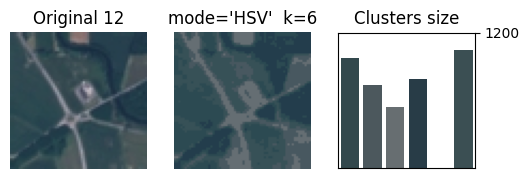

In [ ]:
data = load_images('data/$learning_2', mode='HSV')
plot_Kmeans_analysis(data, mode='HSV', im_num=12, k=6)

In [ ]:
data = load_images('data/$learning_2', mode='Lab')
plot_Kmeans_analysis(data, mode='Lab', im_num=12, k=6)

# DBSCAN

Since DBSCAN method isnt provided with predict method, I have used [this](https://stackoverflow.com/questions/27822752/scikit-learn-predicting-new-points-with-dbscan) implementation

In [ ]:
model = 